In [1]:
#Importing libraries
import tensorflow as tf
import keras 
from keras.models import model_from_json
from keras import backend
import numpy as np

import cv2

%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as matp

import scipy.ndimage
from scipy import misc

import os
import random

import math
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


#### Hyper parameters used in the original paper:

In [2]:
#Block size
B = 16

#Sensing rate R = M/N
#Sensing matrix is MxN
R = 0.25

#Number of reconstruction layers
#K =2 two hidden layers for reconstruction

#Redundancy factor
T = 8

# 1. Data

### 1.1 Reading the images from the file

In [67]:
#unzipping the file
import zipfile
zip_ref = zipfile.ZipFile('Data.zip', 'r') 
zip_ref.extractall('input_data') 
zip_ref.close()

In [3]:
#Reads all the images from the file and save them in a list as Type=unit8
#3-channels of the images share the same info. So one channel is only used
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        
        imagePath = os.path.join(folder,filename)
        
        if imagePath == folder + '.DS_Store':
            continue
        else:
            img = cv2.imread(imagePath,cv2.IMREAD_UNCHANGED)
            if img is not None:
                images.append(img[:,:,0])
                
    return images

In [4]:
images = load_images_from_folder('input_data/Data')

In [5]:
#test
print(type(images))
print(len(images))
print(images[0].shape)
print(images[0].dtype)
np.max(images[0])

<class 'list'>
100
(768, 1024)
uint8


254

In [6]:
#image shape
img_shape = images[0].shape

### 1.2 Compression and Decompression

In [7]:
#This function gets all the images and split them into blocks of BxB and save each block into a row of an array
def compression(image,B):#B is 16
    R = len(image)
    C = len(image[0])
    res = []
    
    for r in range(0,R,B):
        for c in range(0,C,B):
            #segment BxB blocks and faltten them into a vector with len=B^2
            tmp = image[r:B+r,c:c+B].flatten()
            res.append(tmp)
            
    return np.asarray(res)    

#This function gets an array with shape = (len(image)xlen(image[0])/B^2,B^2)
#Returns and image with shape len(image)xlen(image[0]) 
def decompression(arr,B,img_shape):
    numBlocks_R = int(img_shape[0]/B)
    numBlocks_C = int(img_shape[1]/B)
    
    #makes an empty array
    newImage=np.empty((img_shape[0],img_shape[1]))
    
    for r in range(numBlocks_R):
        for c in range(numBlocks_C):
            
            if arr.size != 0:
                tmp = arr[0].reshape((B,B))
                arr = np.delete(arr,0,0)
                newImage[r*B:(r+1)*B , c*B:(c+1)*B] = tmp
                
    return newImage

### 1.3 Function: Compress all the images and save them into a numpy array

In [8]:
def building_Input(images,B):
    input_X = []
    
    for i in images:
        input_X.extend(compression(i,B))
    return np.asarray(input_X)

In [9]:
#Test
test = building_Input(images,B)

In [10]:
#Each image construct 3072 images = 768/16 * 1024/16
print(len(test))
print(type(test))
print(len(test[0]))#should be B*B

307200
<class 'numpy.ndarray'>
256


### 1.4 Splitting Data 

In [11]:
#Split your data to test and train
X_train_Or, X_test_Or, y_train_Or, y_test_Or = train_test_split(images,images, test_size=0.30, random_state=42)

In [12]:
print("Number of images in Training set: ",len(X_train_Or))
print("Number of images in Test set: ",len(X_test_Or))

Number of images in Training set:  70
Number of images in Test set:  30


In [13]:
def save_images_to_folder(folder,img_name,images):
    path = folder+"/"+ img_name
    for i,im in enumerate(images):
        cv2.imwrite(path+str(i)+'.JPEG',im)  
    return 

In [15]:
#Saving images in to a file
save_images_to_folder('train','train_',X_train_Or)
save_images_to_folder('test','test_',X_test_Or)

### 1.5 Making data ready for training

In [14]:
#Train
X_train = building_Input(X_train_Or,B)
y_train = X_train

#Test
X_test = building_Input(X_test_Or,B)
y_test = X_test

In [15]:
print("Number of blocks in Training set: ",len(X_train))
print("Number of blocks in Test set: ",len(X_test))

Number of blocks in Training set:  215040
Number of blocks in Test set:  92160


In [16]:
#cheking the dimensions
#105 images in training
print(X_train.shape)
print(y_train.shape)
#45 images in test
print(X_test.shape)
print(y_test.shape)

(215040, 256)
(215040, 256)
(92160, 256)
(92160, 256)


### 1.6 Feature Scaling

In [116]:
X_train

array([[ 68,  68,  68, ..., 160, 160, 160],
       [ 68,  68,  68, ...,  74,  74,  74],
       [ 68,  68,  68, ...,  74,  74,  74],
       ...,
       [176, 176, 176, ...,  68,  68,  68],
       [176, 176, 176, ...,  68,  68,  68],
       [174, 174, 174, ...,  68,  68,  68]], dtype=uint8)

# 2. Building the Model

### 2.1 Adding Layers

In [17]:
def build_Model(B,R,T):
    ##Set random seeds
    np.random.seed(23)
    tf.set_random_seed(23)
    
    #Creates a model
    model = keras.models.Sequential()
    
    #Add layers
    #First hidden layer
    model.add(
         keras.layers.Dense(
                            units = int(B*B*R),
                            input_dim = B*B,
                            kernel_initializer = 'glorot_uniform',
                            bias_initializer='zeros',
                            activation = 'relu'))

    #First Reconstruction Layer
    model.add(
         keras.layers.Dense(
                            units = B*B*T,
                            input_dim = B*B*R,
                            kernel_initializer = 'glorot_uniform',
                            bias_initializer='zeros',
                            activation = 'relu'))

    #Second Reconstruction Layer
    model.add(
         keras.layers.Dense(
                            units = B*B*T,
                            input_dim = B*B*T,
                            kernel_initializer = 'glorot_uniform',
                            bias_initializer='zeros',
                            activation = 'relu'))

    #Output Layer
    #If you don't specify any activation, no activation is applied. "linear" activation: a(x) = x).
    model.add(
         keras.layers.Dense(
                            units = B*B,
                            input_dim = B*B*T,
                            kernel_initializer = 'glorot_uniform',
                            bias_initializer='zeros'))
    return model

In [18]:
model = build_Model(B,R,T)

In [19]:
#A custome metric function
#https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio

def PSNR(y_true, y_pred):
    
    max_I = 255.0 
    
    loge = 10.0 * backend.log((max_I ** 2) / (backend.mean(backend.square(y_pred - y_true)))) 
    log10 = loge/backend.log(10.0)#backend.log is not base 10
    
    return log10

### 2.2 Optimizer and Cost Function

In [20]:
#Choose optimizer and a cost function

RMSprop_optimizer = keras.optimizers.RMSprop(lr=0.00001, rho=0.9, epsilon=None, decay=1e-7)

model.compile(optimizer = RMSprop_optimizer , loss = 'mean_squared_error', metrics=[PSNR])

In [21]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_2 (Dense)              (None, 2048)              133120    
_________________________________________________________________
dense_3 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dense_4 (Dense)              (None, 256)               524544    
Total params: 4,870,464
Trainable params: 4,870,464
Non-trainable params: 0
_________________________________________________________________
None


### 2.3 Callbacks

In [22]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.PSNR = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.PSNR.append(logs.get('PSNR'))

In [23]:
loss_history = LossHistory()

### 2.3 Training the model

In [24]:
#Training
history = model.fit(X_train, y_train,
                    batch_size=64, epochs =50,
                    verbose = 1,#can follow the optimization during training
                    validation_data=(X_test, y_test),
                    callbacks=[loss_history])# check if the model overfitting by having validation set

Train on 215040 samples, validate on 92160 samples
Epoch 1/50
215040/215040 [==============================] - 32s 150us/step - loss: 339.2591 - PSNR: 29.7219 - val_loss: 40.2439 - val_PSNR: 33.4051
Epoch 2/50
215040/215040 [==============================] - 29s 134us/step - loss: 36.4162 - PSNR: 33.1760 - val_loss: 31.2221 - val_PSNR: 34.7213
Epoch 3/50
215040/215040 [==============================] - 29s 133us/step - loss: 30.7791 - PSNR: 33.8988 - val_loss: 27.5395 - val_PSNR: 35.3147
Epoch 4/50
215040/215040 [==============================] - 29s 133us/step - loss: 27.6769 - PSNR: 34.3390 - val_loss: 27.0058 - val_PSNR: 34.9682
Epoch 5/50
215040/215040 [==============================] - 35s 163us/step - loss: 25.6266 - PSNR: 34.6694 - val_loss: 24.5294 - val_PSNR: 35.5671
Epoch 6/50
215040/215040 [==============================] - 29s 134us/step - loss: 24.1046 - PSNR: 34.9937 - val_loss: 22.6437 - val_PSNR: 36.1108
Epoch 7/50
215040/215040 [==============================] - 31s 14

#### 2.3.1 Saving the Model and the History

In [25]:
#Saving the model 

model_json = model.to_json()
with open("model3_B16_4.json", "w") as json_file:
    json_file.write(model_json)
    
model.save_weights("model3_B16_4.h5")
print("Saved model to disk")

Saved model to disk


In [26]:
#save the history of training
import pickle
pickle_out = open("history3_B16_4.pickle","wb")
pickle.dump(history.history, pickle_out)
pickle_out.close()

#### 2.3.2 Uploading the Model and the History 

In [ ]:
#load your model

json_file = open('model3_B8.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

model = model_from_json(loaded_model_json)
model.load_weights("model3_B8.h5")

In [ ]:
#if you load your model and weights you need to compile it again
model.compile(optimizer = adam_optimizer , loss = 'mean_squared_error', metrics=[PSNR])

# 3.Predicting

In [27]:
y_train_pred = model.predict(X_train,verbose = 1)
y_test_pred = model.predict(X_test,verbose = 1)

92160/92160 [==============================] - 4s 47us/step


In [28]:
y_train_pred

array([[ 70.63086 ,  86.859474,  67.578804, ..., 154.94643 , 155.33585 ,
        152.61601 ],
       [ 73.9377  ,  71.61801 ,  69.59983 , ...,  78.48936 ,  83.26727 ,
         75.50522 ],
       [ 67.730606,  67.81566 ,  68.129875, ...,  73.65058 ,  73.25934 ,
         72.03856 ],
       ...,
       [176.05005 , 176.25064 , 177.45396 , ...,  65.805145,  66.06315 ,
         66.27425 ],
       [176.23749 , 176.23413 , 177.52777 , ...,  66.483665,  66.48071 ,
         66.65703 ],
       [174.20203 , 175.60468 , 176.42014 , ...,  67.92378 ,  71.23407 ,
         57.95832 ]], dtype=float32)

In [29]:
y_test_pred

array([[ 72.043976,  65.50497 ,  70.65434 , ..., 141.42813 , 134.42648 ,
        135.2231  ],
       [ 56.776886,  59.66513 ,  71.91132 , ...,  71.26948 ,  67.26304 ,
         60.83184 ],
       [ 68.11685 ,  67.99191 ,  67.93901 , ...,  71.979866,  71.85814 ,
         70.47598 ],
       ...,
       [176.92657 , 177.10934 , 178.07225 , ...,  63.507515,  63.06833 ,
         63.39631 ],
       [176.69958 , 176.37405 , 177.4514  , ...,  63.71418 ,  63.20855 ,
         63.769547],
       [175.16904 , 174.56465 , 175.21162 , ...,  65.355286,  69.48415 ,
         57.93066 ]], dtype=float32)

# 4. Evaluation

In [30]:
#Evaluate on the whole image
imgL = int(img_shape[0]*img_shape[1]/(B*B))

scores_Train = model.evaluate(X_train, y_train, verbose=1,batch_size=imgL)

print("Training PSNR:")
print("%s: %.2f%%" % (model.metrics_names[1], scores_Train[1]))

215040/215040 [==============================] - 1s 6us/step
Training PSNR:
PSNR: 37.66%


In [31]:
scores_Test = model.evaluate(X_test, y_test, verbose=1,batch_size=imgL)

print("Test PSNR:")
print("%s: %.2f%%" % (model.metrics_names[1], scores_Test[1]))

92160/92160 [==============================] - 1s 7us/step
Test PSNR:
PSNR: 37.42%


### 4.1 Plots

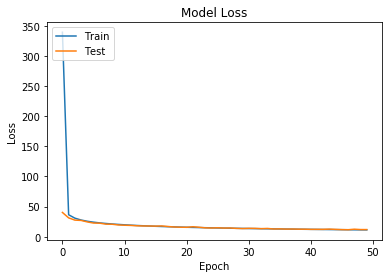

In [32]:
#plotting Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

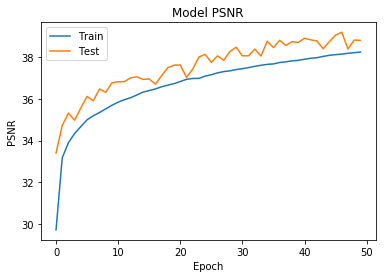

In [33]:
#plotting PSNR
plt.plot(history.history['PSNR'])
plt.plot(history.history['val_PSNR'])
plt.title('Model PSNR')
plt.ylabel('PSNR')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# 5. Reconstrcut the predicted images

### 5.1 Function: reconstrcution

In [34]:
#number of rows for each image = (len(image)xlen(image[0])/B^2
#gets an array and reconstruct the images
def building_output(result,img_shape):
    
    imgL = int(img_shape[0]*img_shape[1]/(B*B))
    out_put = []
    
    for i in range(0,len(result),imgL):
        out_put.append(decompression(result[i:i+imgL],B,img_shape))
    
    return out_put

### 5.2 Reconstrcuting train and test

In [35]:
#reconstructing train predictions
dec_img_train = building_output(y_train_pred,img_shape)

#reconstructing test predictions
dec_img_test = building_output(y_test_pred,img_shape)

In [36]:
#test
print(len(dec_img_train))
print(len(dec_img_test))

70
30


### 5.3 Plotting images

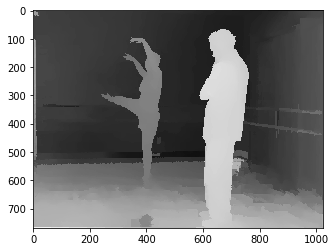

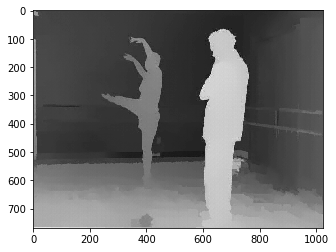

37.740607515864426


In [38]:
#train
img_in=X_train_Or[50]
img_out = dec_img_train[50]
imgplot = plt.imshow(img_in,cmap='gray')
plt.show()
imgplot = plt.imshow(img_out,cmap='gray')
plt.show()
print(PSNR_Final(img_in,img_out))#PSNR_Final is in section 5.4

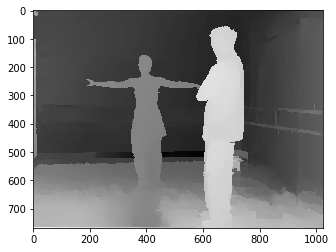

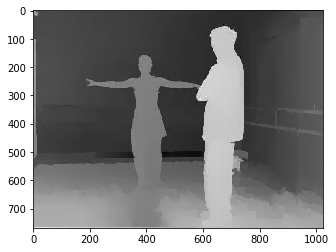

37.812382421049314


In [39]:
#test
img_in_t=X_test_Or[15]
img_out_t = dec_img_test[15]
imgplot = plt.imshow(img_in_t,cmap='gray')
plt.show()
imgplot = plt.imshow(img_out_t,cmap='gray')
plt.show()
print(PSNR_Final(img_in_t,img_out_t))

### 5.3 Saving images

In [40]:
def save_images_to_folder(folder,img_name,images):
    path = folder+"/"+ img_name
    for i,im in enumerate(images):
        cv2.imwrite(path+str(i)+'.png',im)  
    return 

In [41]:
#saving the precited images
save_images_to_folder('train_pred_B8_3','train_p_B16_2_',dec_img_train)
save_images_to_folder('test_pred_B8_3','test_p_B16_2_',dec_img_test)

### 5.4 Find the average PSNR 

In [37]:
#Calculate PSNR on the whole image
def PSNR_Final(y_true, y_pred):
    max_I = 255.0 #in this dataset #double check with get the max(img)
    tmp =  np.mean(np.square(y_pred - y_true))
    log_res = 10 * np.log10((max_I ** 2) /tmp)
    
    return log_res

In [42]:
#calcualte the average PSNR on a data set
def cal_PSNR_Dataset(output_images,input_images):
    res_psnr = []
    for i,o in enumerate(output_images):
        res_psnr.append(PSNR_Final(input_images[i],o))
    return res_psnr

In [43]:
res_psnr_train = cal_PSNR_Dataset(dec_img_train,X_train_Or)
print("average PSNR on training: ",np.mean(res_psnr_train))

average PSNR on training:  37.66420542988648


In [44]:
res_psnr_train

[37.39037397906721,
 37.609450045219866,
 37.8648941019286,
 37.77667997980268,
 37.629268515799104,
 38.3764944258415,
 37.01947711038219,
 37.22501991289376,
 37.811342391675126,
 37.38785222753997,
 37.24322599220015,
 37.99870707497102,
 37.76241508699891,
 38.07215069899865,
 37.75948935639256,
 37.48227825693742,
 37.02048628153851,
 37.51872697723399,
 37.633757405448584,
 36.806785373270344,
 37.904913600807745,
 37.93308269895154,
 38.17964861926975,
 37.62749560168393,
 37.65773410163038,
 36.85061808577271,
 37.351705604411926,
 37.593804029511766,
 37.88944405767176,
 37.88105066125294,
 37.18914800489742,
 38.12339221494198,
 37.87124673304945,
 38.11933918023505,
 37.99533227978191,
 37.84295626965565,
 37.66642576549263,
 37.01848471869609,
 37.87627246712995,
 37.9326765071662,
 37.597494436230576,
 37.69822340979098,
 37.186728939890116,
 38.101478464482234,
 37.769909575202945,
 37.05992674525045,
 37.354815847473596,
 37.414421657657265,
 37.74683157275633,
 37.51380

In [45]:
res_psnr_test = cal_PSNR_Dataset(dec_img_test,X_test_Or)
print("average PSNR on the test set: ",np.mean(res_psnr_test))

average PSNR on the test set:  37.41756269920125


In [46]:
res_psnr_test

[37.43099003483168,
 37.53210268056367,
 38.02006077295857,
 37.776208040374144,
 37.870004364037435,
 37.49744601870485,
 37.39994636657535,
 37.73253996211048,
 37.235516164960046,
 37.752871125047406,
 37.56602971470598,
 37.48003679672475,
 36.7440669771665,
 37.40704896332731,
 37.751061115976434,
 37.812382421049314,
 37.16205702290983,
 36.955983329240716,
 37.33140094431842,
 37.56802732305762,
 37.359051650725135,
 36.96664169589111,
 37.50041490805487,
 36.83433848091868,
 37.58361825435655,
 37.50536426392647,
 37.58715606447042,
 36.631832037403626,
 37.167833907536775,
 37.36484957411364]